In [4]:
# Title: Contact models for atomic force microscopy
# Author: J. P. S. Ferreira
# Date: 2023-01-17
# Description: This notebook is a draft for a work on contact models for atomic force microscopy. It is a work in progress.
# Literature: 
# (1) https://www.sciencedirect.com/science/article/pii/S0968432822000245 
# (2) https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3010-3
# License: MIT

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Hertz and JKR functions

In [6]:
def hertz(i, E, nu, r):
    """Hertz model for indentation.
    
    approximation for parabolic indenter.
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    R : float
        Radius of the indenter/probing tip.
        
    Returns
    -------
    float
        Contact force.
    """
    # 'a' and 'factor' calculated based on ref (2)
    # search for other formulas to obtain these parameters
    a = i/r
    factor = 1 - 0.1 * a - (1/840) * a**2 + (11/15120) * a**3 + (1357/6652800) * a**4
    force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

#Johnson-Kendall-Roberts model for indentation
#(3) https://lizidelcidphd.com/2017/07/07/the-simplified-johnson-kendall-roberts-model/
def jkr(i, E, nu, gamma, r):
    """Johnson-Kendall-Roberts model for indentation.
    
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    gamma : float
        Surface energy.
    R : float
        Radius of the indenter.
        
    Returns
    -------
    float
        Contact force.
    """
    # JKR force formula in (3)
    force = E * r **0.5 * i**1.5 - gamma * E**0.5 * r**0.75 * i**0.75
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

## Parameter definition

(array([ 5.,  5.,  6., 15., 19., 19., 21., 32., 40., 37., 41., 52., 25.,
        22., 22., 16.,  9.,  7.,  4.,  3.]),
 array([0.24912969, 0.32352026, 0.39791083, 0.47230139, 0.54669196,
        0.62108253, 0.6954731 , 0.76986366, 0.84425423, 0.9186448 ,
        0.99303536, 1.06742593, 1.1418165 , 1.21620707, 1.29059763,
        1.3649882 , 1.43937877, 1.51376934, 1.5881599 , 1.66255047,
        1.73694104]),
 <BarContainer object of 20 artists>)

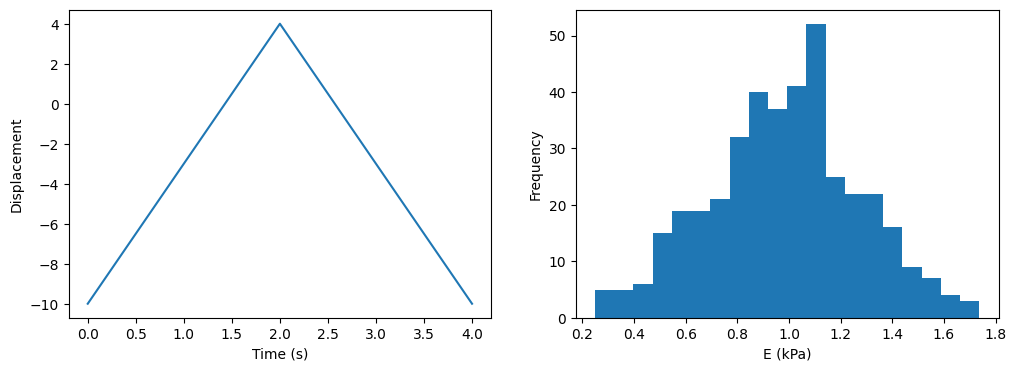

In [7]:
# resolution of the map
res = 20
# random values
size = res * res
# Young's modulus [kPa] - random values following a normal distribution
    #loc: mean/center of distribution
    #scale: std
E = np.random.normal(loc=1.0, scale=0.3, size=size)
# Poisson's ratio 
nu = 0.5
# surface energy
    #gamma in (3) is given in J sub-units(???), but gamma <> Ua
gamma = 0.1
# radius of the indenter
r = 1.0
# no contact approach. less points
#linspace(p1, p2, n_pts)
no_contact = np.linspace(-10, 0, 3)
# indentation depth. more points
contact = np.linspace(0, 4, 20)
# approach and withdraw
approach = np.concatenate([no_contact[:-1], contact])
withdraw = np.flip(approach)
ramp = np.concatenate([approach, withdraw])
# define ramp time
half_cycle = 2 
t_approach = half_cycle*((approach - approach.min(axis=0)) / (approach.max(axis=0) - approach.min(axis=0)))
t_withdraw = half_cycle*((withdraw - withdraw.max(axis=0)) / (withdraw.min(axis=0) - withdraw.max(axis=0)))+max(t_approach)
t = np.concatenate([t_approach, t_withdraw])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Displacement')
ax1.plot(t, ramp)
ax2.set_xlabel('E (kPa)')
ax2.set_ylabel('Frequency')
ax2.hist(E, 20)


## Initial df

In [8]:
# construct dataframe
df = pd.DataFrame()
# 'E' array to list:
df['E'] = E.tolist()
# assigns the displacement array for each 'E' (num of E values = len(df) = size)
df['approach'] = [approach for _ in range(len(df))]
df['withdraw'] = [withdraw for _ in range(len(df))]
# applies hertz and jkr models to each row (axis= 0(col) or 1(row))
    # x will take the values of each row 
df['f_hertz'] = df.apply(lambda x: hertz(x.approach, x.E, nu, r), axis=1)
df['f_jkr'] = df.apply(lambda x: jkr(x.withdraw, x.E, nu, gamma, r), axis=1)

C:\Users\luisr\AppData\Local\Temp\ipykernel_21392\3838886906.py:25: RuntimeWarning: invalid value encountered in power
  force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
C:\Users\luisr\AppData\Local\Temp\ipykernel_21392\3838886906.py:54: RuntimeWarning: invalid value encountered in power
  force = E * r **0.5 * i**1.5 - gamma * E**0.5 * r**0.75 * i**0.75


## Initial df - plots

(4.7, -10.7, -0.8395747863526948, 17.63107051340659)

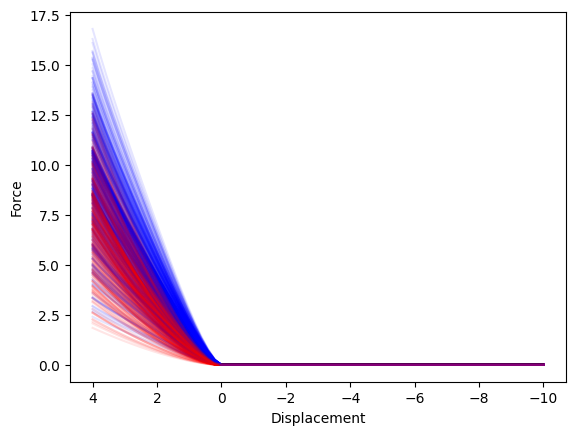

In [9]:
# plot all entries naively
# i: row index; row: data of each row in series format
for i, row in df.iterrows():
    #alpha: transparecy
    plt.plot(row['approach'], row['f_hertz'], color='blue', alpha=0.1)
    plt.plot(row['withdraw'], row['f_jkr'], color='red', alpha=0.1)
#add labels
plt.xlabel('Displacement')
plt.ylabel('Force')
# invert x axis
# plt.axis() returns (xmin, xmax, ymin, ymax)
ax = plt.axis()
plt.axis((ax[1],ax[0],ax[2],ax[3]))

C:\Users\luisr\AppData\Local\Temp\ipykernel_21392\3231670830.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df2, x='approach', y='f_hertz', palette='Set1', errorbar='sd')
C:\Users\luisr\AppData\Local\Temp\ipykernel_21392\3231670830.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df2, x='withdraw', y='f_jkr',  palette='Set2', errorbar='sd')


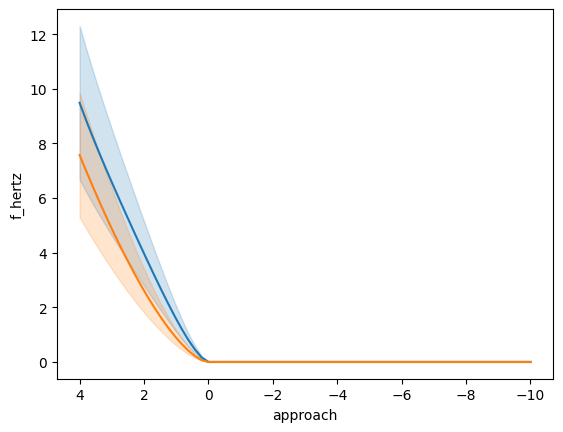

In [10]:
# plot all entries with seaborn
    # set_index: sets 'E' as the index (so the right value o E is assigned to the correct rows after the explode)
    # Series.explode: 'explodes' the arrays (disp and force) into different rows (scalars in each cell instead of arrays)
    # reset_index: because E is no longer needed as an index
df2 = df.set_index(['E']).apply(pd.Series.explode).reset_index()
ax = sns.lineplot(data=df2, x='approach', y='f_hertz', palette='Set1', errorbar='sd')
ax = sns.lineplot(data=df2, x='withdraw', y='f_jkr',  palette='Set2', errorbar='sd')
ax.invert_xaxis()

## Initial df - Mapping E

<AxesSubplot: >

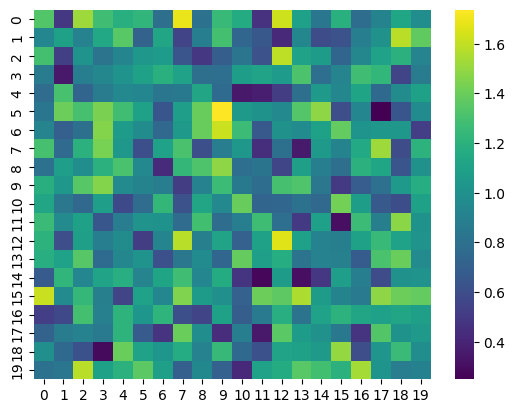

In [11]:
# map random values to a 2D array
#transforms E from array to matrix
E_map = np.reshape(E, (res, res))
# Young's modulus random map
sns.heatmap(E_map, cmap='viridis')
#NOTE: examples at https://seaborn.pydata.org/examples/index.html

<AxesSubplot: >

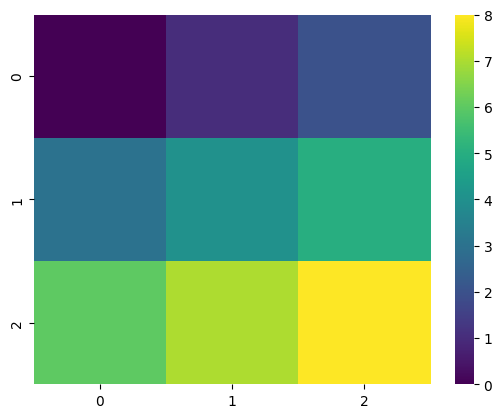

In [12]:
#check reshape rule.
# create sequential integers array of size 9
v = np.arange(0, 9, 1, dtype=int)
# reshape to 3x3
vmap = np.reshape(v, (3, 3))
# print array
sns.heatmap(vmap, cmap='viridis')
#NOTE: reshape rule is row-major, i.e. the first index is the row index. The second index is the column index.

# **HERTZ**

In [31]:
#dataframe with contact-only data
#df_hc: hertz contact
df_hc = pd.DataFrame()
df_hc['approach_contact'] = df['approach'].apply(lambda x: x[x>=0])
df_hc['f_hertz_contact'] = df['f_hertz'].apply(lambda x: x[len(no_contact)-1:])
df_hc['E_hertz'] = df['E']
#df_hc['appproach_contact'] = df.apply(lambda x: x.approach[x.approach>=0], axis=1)
#check size of disp and force vectors
print(df_hc['approach_contact'][0].shape, df_hc['f_hertz_contact'][0].shape)

(20,) (20,)


### Inputs and labels

In [38]:
x_hc = np.array(df_hc[['approach_contact', 'f_hertz_contact']])
y_hc = np.array(df_hc['E_hertz'])
# check array dimensions
print(x_hc.shape, y_hc.shape)

(400, 2) (400,)


### Train-test split

In [49]:
test_ratio = 0.1
rnd_state = None

# Without stratify
x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio, random_state=rnd_state)

#With stratify
bin_count = 20
bins = pd.qcut(y_hc, bin_count)
bins



#fig, (ax3, ax4) = plt.subplots(1,2, figsize=(12,4))
#ax3.set_xlabel('E_train')
#ax3.hist(y_train, 20)
#ax4.set_xlabel('E_test')
#ax4.hist(y_test, 20)


[(1.295, 1.359], (0.486, 0.597], (1.459, 1.737], (1.226, 1.295], (1.181, 1.226], ..., (1.181, 1.226], (1.459, 1.737], (0.993, 1.035], (0.84, 0.879], (0.879, 0.914]]
Length: 400
Categories (20, interval[float64, right]): [(0.248, 0.486] < (0.486, 0.597] < (0.597, 0.66] < (0.66, 0.744] ... (1.226, 1.295] < (1.295, 1.359] < (1.359, 1.459] < (1.459, 1.737]]